## **[ 루브릭 ]**
***

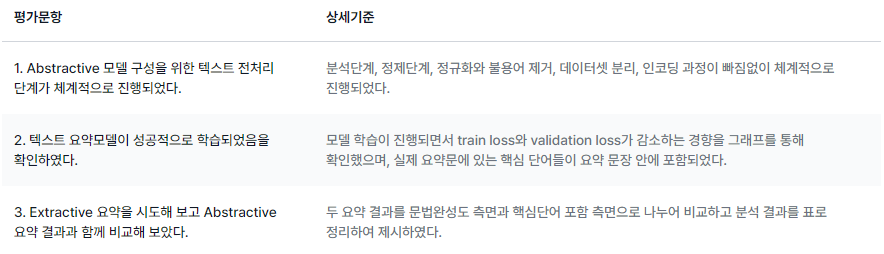

## **Step 0. 라이브러리 불러오기**
***

In [1]:
# 라이브러리 불러오기
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Step 1. 데이터 수집하기**
***

이 데이터는 기사의 본문에 해당되는 `text`와 `headlines` 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 `text`를 본문, `headlines`를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요.

추출적 요약을 하는 경우에는 오직 `text`열만을 사용하세요.

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", 
                           filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
print('Total number of data:', (len(data)))

Total number of data: 98401


In [4]:
data.head(10)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...


## **Step 2. 데이터 전처리하기 (추상적 요약)**
***

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요.

만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### **중복 샘플과 NULL 값이 존재하는 샘플 제거**
***

우선 데이터의 중복 샘플 유무를 확인해 볼게요.

In [5]:
# 데이터의 중복 샘플 유무 확인해보기
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98280
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [6]:
# 데이터의 중복 샘플 제거하기
data.drop_duplicates(subset = ['text'], inplace=True)
print('Total number of data :', (len(data)))

Total number of data : 98360


In [7]:
# 데이터프레임에 Null 값이 있는지 확인하기
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### **텍스트 정규화와 불용어 제거**

**텍스트 정규화(text normalization)**

같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있기에, 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것.

ex. `it'll`은 `it will`과 같고, `mustn't`과 `must not`은 사실 같은 표현

In [8]:
# 나만의 정규화 사전 만들기
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("The number of text normalization dictionary: ", len(contractions))

The number of text normalization dictionary:  120


In [9]:
# 불용어(stopwords) 제거하기
print('The number of stopwords :', len(stopwords.words('english') ))
print(stopwords.words('english'))

The number of stopwords : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 

In [10]:
# 데이터 전처리 함수 만들기

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    # <br />, <a href = ...> 등의 html 태그 제거
    sentence = BeautifulSoup(sentence, "lxml").text
    # 괄호로 닫힌 문자열 (...) 제거
    # Ex) my husband (and myself!) for => my husband for
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions
                         else t for t in sentence.split(" ")]) # 약어 정규화
    # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub(r"'s\b","", sentence)
    # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    sentence = re.sub('[m]{2,}', 'mm', sentence)

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
# Headlines 컬럼의 데이터를 전처리하기
clean_headline = []

for headline in data['headlines']:
    clean_headline.append(preprocess_sentence(headline))

# 전처리 후 출력
print("Result of headline preprocessing: ", clean_headline[:5])

Result of headline preprocessing:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


In [12]:
# text 컬럼의 데이터를 전처리하기
clean_text = []

for text in data['text']:
    clean_text.append(preprocess_sentence(text))

# 전처리 후 출력
print("Result of text preprocessing: ", clean_text[:5])

Result of text preprocessing:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customer

In [13]:
# 전처리한 데이터를 다시 저장하기
data['headlines'] = clean_headline
data['text'] = clean_text

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
# 전처리한 과정에서 null 값이 생겼는지 확인해보기
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [15]:
# 전처리한 과정에서 생긴 null 값 제거하기
data.dropna(axis=0, inplace=True)

In [16]:
print('The number of sample :', (len(data)))

The number of sample : 98360


### **샘플의 최대 길이 정하기**

필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례에요.

headlines와 text의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 볼게요.

In [17]:
# headlines, text의 길이 분포 출력하기
import matplotlib.pyplot as plt

headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 13
헤드라인의 평균 길이 : 7.136183407889386
텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221


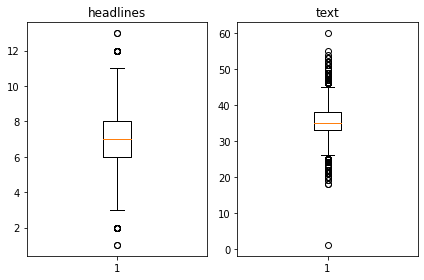

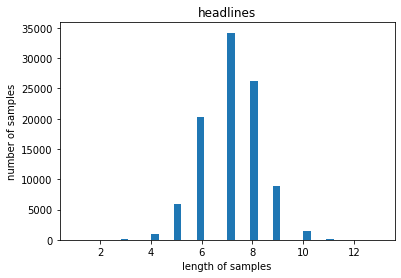

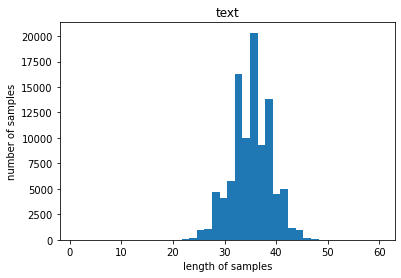

In [18]:
# headlines, text의 길이 분포 시각화하기
plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
# Text의 최대 길이과 Summary의 적절한 최대 길이 정해보기
# IQR을 참조하여, 이상치로 판단될 만한 데이터를 자르는 것이 좋다고 판단함
headlines_max_len = 11
text_max_len = 45

In [20]:
# 우리가 결정한 임의의 길이가 몇 %의 샘플까지 포함하는지 확인하는 함수 정의하기
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [21]:
# 우리가 결정한 임의의 길이가 몇 %의 샘플까지 포함하는지 확인해보기
below_threshold_len(headlines_max_len, data['headlines'])
below_threshold_len(text_max_len,  data['text'])

전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9997458316388776
전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678


In [22]:
# 정해진 길이보다 길면 데이터에서 제외하기
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]

print('Total samples of data :', (len(data)))

Total samples of data : 98021


### **시작 토큰과 종료 토큰 추가하기**

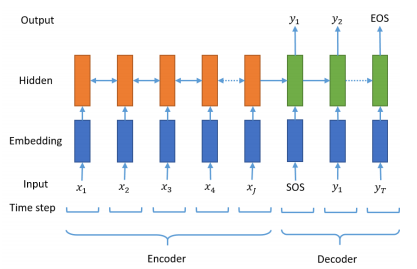

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있어요.

이번 실습에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 거예요.

디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 `decoder_input`, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 `decoder_target`이라고 이름을 정했어요.

> 두 개의 문장 모두 `headlines` 열로부터 만들 거예요.

In [23]:
# 헤드라인 데이터에는 시작 토큰과 종료 토큰 추가하기
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


앞뒤로 토큰이 잘 붙었죠? 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 줄게요.

In [24]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장하기
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

이제 훈련 데이터와 테스트 데이터를 분리할거에요.

우선, `encoder_input`과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줄게요.

In [25]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[91837 48086 29523 ... 11188  8268 45435]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 되겠죠.

In [26]:
# 정수 시퀀스를 이용해 다시 데이터의 샘플 순서 정의하기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄게요.

전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해 줄게요.

In [27]:
# 데이터를 훈련 데이터/테스트 데이터(8:2)로 나누기
n_of_val = int(len(encoder_input)*0.2)
print('The number of test data :', n_of_val)

The number of test data : 19604


이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분할게요

In [28]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('The number of train data :', len(encoder_input_train))
print('The number of train label :', len(decoder_input_train))
print('The number of test data :', len(encoder_input_test))
print('The number of test label :', len(decoder_input_test))

The number of train data : 78417
The number of train label : 78417
The number of test data : 19604
The number of test label : 19604


* **훈련 데이터**는 **78,417개**
* **테스트 데이터**는 **19,604개**

### **단어 집합(vocabulary) 만들기 및 정수 인코딩**

**단어 집합(vocabulary)**
* 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸는 과정
* 각 단어에 고유한 정수를 맵핑하는 작업이 필요함

훈련 데이터에 대해서 단어 집합을 만들어볼게요.

우선, 원문에 해당되는 `encoder_input_train`에 대해서 단어 집합을 만들게요.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.

In [29]:
# 입력된 훈련 데이터로부터 단어 집합 만들기
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요.

현재 생성된 단어 집합은 `src_tokenizer.word_index`에 저장되어 있어요.

그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 해요.

`src_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요.

In [30]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69505
등장 빈도가 6번 이하인 희귀 단어의 수: 47394
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22111
단어 집합에서 희귀 단어의 비율: 68.18790015106828
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.500024733100745


등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 68.07%를 차지하네요.

하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.49%밖에 되지 않아요.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다.

위에서 이를 제외한 단어 집합의 크기를 2만 2천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 20,000으로 제한해볼게요.

In [31]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

`texts_to_sequences()`는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요. 현재 단어 집합의 크기를 20,000으로 제한했으니까 이제 20,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않아요.

In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[32, 65, 2749, 8529, 3, 1486, 180, 1241, 19, 3488, 105, 439, 53, 12573, 2837, 6958, 704, 1400, 10018, 252, 2837, 5034, 802, 143, 413, 721, 7775, 7776, 4945, 5652, 1450], [10, 665, 1354, 17481, 5653, 1227, 1997, 2408, 2242, 2809, 416, 1143, 3234, 280, 189, 673, 3908, 2732, 6, 3737, 189, 2598, 912, 1596, 411, 2838, 89, 1], [78, 349, 6863, 2077, 234, 173, 1293, 17482, 3692, 78, 896, 2422, 798, 1513, 129, 6863, 374, 896, 2549, 2681, 13754, 19436, 1, 5525, 229, 226, 1348, 6959, 374, 896, 2549, 14770, 666, 6, 6161, 8272, 3738, 607]]


이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있어요.

text 데이터에 대해서도 동일한 작업을 수행할게요.

In [33]:
# 입력된 훈련 데이터로부터 단어 집합 만들기
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

In [34]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29838
등장 빈도가 5번 이하인 희귀 단어의 수: 19563
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10275
단어 집합에서 희귀 단어의 비율: 65.5640458475769
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.878247613789989


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 65.64%를 차지하고 있네요.

하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.88%밖에 되지 않아요.

In [35]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 365, 5294, 21, 582, 130, 21, 8, 1791], [1, 30, 223, 1333, 2297, 793, 1494, 600], [1, 28, 39, 4410, 1704, 6048, 3111], [1, 9, 75, 341, 199, 730, 2683, 311, 753], [1, 541, 1495, 941, 284, 2791, 460, 3197]]
target
decoder  [[365, 5294, 21, 582, 130, 21, 8, 1791, 2], [30, 223, 1333, 2297, 793, 1494, 600, 2], [28, 39, 4410, 1704, 6048, 3111, 2], [9, 75, 341, 199, 730, 2683, 311, 753, 2], [541, 1495, 941, 284, 2791, 460, 3197, 2]]


In [36]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 4
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78413
훈련 레이블의 개수 : 78413
테스트 데이터의 개수 : 19604
테스트 레이블의 개수 : 19604


### **패딩하기**

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요.

최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [37]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

이제 학습에 필요한 데이터 전처리가 모두 끝났어요.

## **Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)**
***

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요.

실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

이제는 모델을 설계할 시간이에요. 우선 함수형 API를 이용해서 인코더를 설계해 볼게요.

In [38]:
# LSTM을 사용하여 출력과 상태를 생성하기
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h3, state_c3 = encoder_lstm3(encoder_output2)

# 인코더 모델 정의
encoder_states = [state_h3, state_c3]

1. 임베딩 벡터의 차원과 hidden state의 크기
* 임베딩 벡터의 차원을 128로 정의합니다.
* hidden state의 크기는 256으로 설정합니다. 이는 LSTM의 용량을 나타내며, 뉴런의 개수로 이해할 수 있습니다.
2. 인코더의 LSTM 층 구성
* 인코더는 총 3개의 LSTM 층으로 구성됩니다. 이는 모델의 복잡도를 높이는 방법 중 하나입니다.
* 각 LSTM 층은 dropout과 recurrent dropout을 사용하여 과적합을 방지합니다.
3. 어텐션 메커니즘
* 어텐션 레이어는 인코더의 출력 벡터와 디코더의 입력 벡터 사이의 관계를 학습합니다.
* 이를 통해 디코더가 인코더의 중요한 부분에 집중할 수 있도록 합니다.
4. 모델 구성
* 인코더와 디코더를 연결하여 Seq2Seq 모델을 구성합니다.
* 모델을 컴파일하고 학습합니다.

이제 디코더를 설계해볼게요.

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일해요.


하지만 LSTM의 입력을 정의할 때, `initial_state`의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 해요.

디코더의 출력층을 설계해볼게요.

In [40]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 `tar_vocab`의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 해요.

그렇기 때문에 Dense의 인자로 `tar_vocab`을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있어요.

### **어텐션 메커니즘**

어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻이에요.

ensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 알아볼게요.

In [41]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있어요.

### **모델 훈련하기**

설계한 모델을 가지고 훈련을 진행해볼게요.

In [42]:
# 모델 훈련하기
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy')
# EarlyStopping 설정하기
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 35s 93ms/step - loss: 5.1216 - val_loss: 4.7462
Epoch 2/50
307/307 [==============================] - 28s 91ms/step - loss: 4.5851 - val_loss: 4.4322
Epoch 3/50
307/307 [==============================] - 29s 93ms/step - loss: 4.3011 - val_loss: 4.1903
Epoch 4/50
307/307 [==============================] - 29s 95ms/step - loss: 4.0689 - val_loss: 4.0339
Epoch 5/50
307/307 [==============================] - 30s 97ms/step - loss: 3.8797 - val_loss: 3.8814
Epoch 6/50
307/307 [==============================] - 30s 99ms/step - loss: 3.7226 - val_loss: 3.8018
Epoch 7/50
307/307 [==============================] - 30s 98ms/step - loss: 3.5874 - val_loss: 3.7260
Epoch 8/50
307/307 [==============================] - 30s 98ms/step - loss: 3.4679 - val_loss: 3.6531
Epoch 9/50
307/307 [==============================] - 30s 98ms/step - loss: 3.3627 - val_loss: 3.6122
Epoch 10/50
307/307 [==============================] - 30s 98ms/step - loss: 3.267

`EarlyStopping`은 특정 조건이 충족되면 훈련을 멈추는 역할을 해요.

`val_loss`(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 3회(patience=3) 관측되면 학습을 멈추도록 설정돼 있어요.

`EarlyStopping`이 작동한다면 `epochs`가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있겠네요.

이제 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 해봐요.






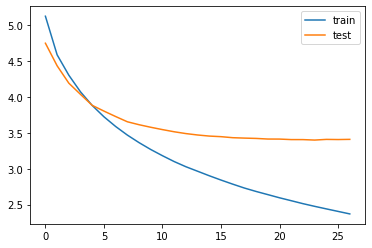

In [43]:
# 이제 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화하기
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

1. 초기 손실 값: 초기 epoch에서는 두 손실 값 모두 높게 시작함. 모델이 아직 충분히 학습되지 않았음.
2. 손실 감소: epoch가 진행됨에 따라 두 곡선 모두 손실이 감소함. 모델이 훈련 데이터에 적응하고 학습하고 있음.
3. 검증 손실 감소: 초기 epoch에서는 검증 데이터셋의 손실도 감소하지만, 훈련 데이터셋의 손실보다 느린 속도로 감소함.
4. 수렴: 일정 epoch 이후에는 검증 데이터셋의 손실이 거의 일정해지며 더 이상 크게 감소하지 않음. 모델이 더 이상의 일반화 성능을 얻기 어려움. 반면, 훈련 데이터셋의 손실은 계속 감소하고 있음.
5. 과적합(Overfitting): 훈련 데이터셋의 손실은 계속해서 감소하는 반면, 검증 데이터셋의 손실은 일정한 수준에서 유지되거나 약간 증가하는 모습은 모델이 과적합되고 있을 가능성이 있음. 즉, 모델이 훈련 데이터에 너무 맞춰져서 새로운 데이터에 대한 일반화 성능이 떨어질 수 있다는 것을 의미함.

1. 옵티마이저(Optimizer): Adam
적응적 학습률: Adam은 각 매개변수에 대해 학습률을 개별적으로 조정할 수 있음. 이로 인해 훈련이 더 빠르고 효율적으로 진행될 수 있음.
모멘텀 및 RMSProp의 결합: Adam은 모멘텀과 RMSProp의 장점을 결합하여, 기울기의 일관된 방향을 따르면서도, 과도한 진동을 억제할 수 있음.
2. 손실 함수(Loss): Binary Crossentropy
이진 분류: 문제의 본질이 이진 분류 문제일 때, binary crossentropy는 가장 적합한 손실 함수
확률 기반: 이 함수는 모델의 출력이 특정 클래스일 확률을 최대화하는 방향으로 학습을 진행함.

### **인퍼런스 모델 구현하기**

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [44]:
# 필요한 3개의 사전 준비하기

# 원문 단어 집합에서 정수 -> 단어를 얻음
src_index_to_word = src_tokenizer.index_word
# 요약 단어 집합에서 단어 -> 정수를 얻음
tar_word_to_index = tar_tokenizer.word_index
# 요약 단어 집합에서 정수 -> 단어를 얻음
tar_index_to_word = tar_tokenizer.index_word

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 합니다.

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 모델 하나만 준비할 수 있습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다.

이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, encoder_states])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계할 수 있습니다.

In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들 수 있습니다.

In [74]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    encoder_output = encoder_model.predict(input_seq)
    
    if len(encoder_output) == 2:
        e_out, e_h = encoder_output
        e_c = None  # 셀 상태가 없는 경우
    else:
        e_out, e_h, e_c = encoder_output

    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        if e_c is not None:
            predictions = decoder_model.predict([target_seq, e_out, e_h, e_c])
        else:
            predictions = decoder_model.predict([target_seq, e_out, e_h])

        if len(predictions) == 2:
            output_tokens, h = predictions
            c = None
        else:
            output_tokens, h, c = predictions

        # 예측된 토큰의 인덱스를 얻음
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word.get(sampled_token_index, '')

        if sampled_token != 'eostoken':
            decoded_sentence += sampled_token + ' '

        # 종료 조건: 최대 길이 도달 또는 <eostoken> 예측
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len - 1):
            stop_condition = True
        
        # 업데이트를 위해 타겟 시퀀스를 갱신
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        
        # 상태를 업데이트
        e_h = h
        if c is not None:
            e_c = c

    return decoded_sentence.strip()

## **Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)**
***

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [75]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 헤드라인의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        # sostoken과 eostoken을 무시하고 패딩(0)도 무시
        if i != 0 and tar_index_to_word.get(i) != 'sostoken' and tar_index_to_word.get(i) != 'eostoken':
            temp += tar_index_to_word.get(i, '') + ' '
    return temp.strip()

테스트 데이터 약 50개의 샘플에 대해서 실제 헤드라인과 요약된 헤드라인을 비교해보세요.

In [76]:
for i in range(50, 100):
    print("Text:", seq2text(encoder_input_test[i]))
    print("Real Headlines:", seq2headlines(decoder_input_test[i]))
    print("Predict Headlines:", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

Text: kerala chief minister pinarayi vijayan saturday said pm modi led central government taking pro america anti china stand foreign policies america policies according interests include stand took china india decides foreign policies accordance interest america every move made america china said 
Real Headlines: centre pro america anti china policies kerala cm
Predict Headlines: india china sign plan china cm


Text: defeating west african boxing union middleweight champion indian boxer vijender singh said next aims win commonwealth world championship titles commonwealth super middleweight title currently held great britain luke year old boxer wins including eight knockouts fights 
Real Headlines: look forward fighting world title next vijender
Predict Headlines: boxer wins bronze boxing boxing title


Text: pakistan test captain misbah ul haq called life ban anyone found guilty fixing adding investigation five players caught spot fixing pakistan super league threatened years work cl

## **Step 5. Summa을 이용해서 추출적 요약해보기**
***

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요.

반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

`Summa`의 `summarize`를 사용하여 추출적 요약을 해보세요.

### **데이터 다운로드**

In [77]:
!pip install summa

In [100]:
import requests
from summa.summarizer import summarize

In [109]:
# text를 news_text에 저장하기
news_text = data['text']

In [110]:
print(news_text[:1500])

0       saurav kant alumnus upgrad iiit pg program mac...
1       kunal shah credit card bill payment platform c...
2       new zealand defeated india wickets fourth odi ...
3       aegon life iterm insurance plan customers enjo...
4       speaking sexual harassment allegations rajkuma...
                              ...                        
1507    part viral yearchallenge anil kapoor shared co...
1508    janhvi kapoor sister khushi kapoor appear toge...
1509    reigning champions vidarbha beat uttarakhand i...
1510    world number one romania simona halep beat sev...
1511    indian para powerlifter vikramsingh adhikari h...
Name: text, Length: 1500, dtype: object


### **Summarize 사용하기**

Summa의 `summarize()`의 인자로 사용되는 값들에 대해서 알아볼게요.

> **text (str)** : 요약할 테스트.
>
> **ratio (float, optional)** – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
>
> **words (int or None, optional)** – 출력에 포함할 단어 수. 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
>
> **split (bool, optional)** – True면 문장 list / False는 조인(join)된 문자열을 반환

In [126]:
# 텍스트를 요약하는 함수 정의하기
def summarize_text(text):
    if isinstance(text, str) and len(text) > 10:  # 텍스트가 충분히 길 경우에만 요약 수행
        summary = summarize(text, words=50)
        return summary if summary else text  # 요약이 없으면 원래 텍스트 반환
    return text  # 텍스트가 짧으면 원래 텍스트 반환

In [127]:
# 요약 함수를 텍스트 열의 각 행에 적용하기
data['predicted_headlines'] = news_text.apply(summarize_text)

In [128]:
# 출력 옵션 설정: 각 셀의 최대 길이를 None으로 설정하여 생략되지 않도록 함
pd.set_option('display.max_colwidth', None)

In [129]:
# 실제 헤드라인과 예측 헤드라인을 출력
result = data[['headlines', 'predicted_headlines']]
print(result.head(10))

                                                       headlines  \
0               upgrad learner switches career ml al salary hike   
1               delhi techie wins free food swiggy one year cred   
2    new zealand end rohit sharma led india match winning streak   
3       aegon life iterm insurance plan helps customers save tax   
4                       known hirani yrs metoo claims true sonam   
5  rahat fateh ali khan denies getting notice smuggling currency   
6                         india get lowest odi total new zealand   
7               govt directs alok verma join work day retirement   
8                 called pm modi sir times satisfy ego andhra cm   
9           cong wins ramgarh bypoll rajasthan takes total seats   

                                                                                                                                                                                                                                                           

## **STEP 6. 결과 비교분석하기**
***

### **추상적 요약 결과**

예측 헤드라인이 실제 헤드라인의 주요 요소를 반영하고 있으나, 몇몇 경우에는 실제 헤드라인보다 구체성이 떨어지거나 잘못된 정보를 포함하고 있습니다.

1. [케랄라 CM의 발언] : 실제 헤드라인은 중앙정부의 친미 반중 정책을 명시적으로 언급하고 있으며, 예측 헤드라인은 인도와 중국 간의 협약을 잘못 언급하고 있음.
2. [복싱 선수 비제이더 싱의 목표] : 실제 헤드라인은 비제이더 싱의 다음 목표를 명확히 언급하고 있으나, 예측 헤드라인은 동메달과 관련된 잘못된 정보를 포함하고 있음.
3. [파키스탄 크리켓 선수 미스바 울 하크의 발언] : 실제 헤드라인은 미스바의 발언을 정확히 반영하지만, 예측 헤드라인은 잘못된 내용을 포함하고 있음.
4. [비라트 콜리와 아누쉬카 샤르마의 출연] : 예측 헤드라인이 실제 헤드라인과 매우 유사함
5. [리오넬 메시의 인터뷰] : 실제 헤드라인이 메시의 발언 내용을 더 정확히 반영함.
6. [아밋 샤의 발언] : 실제 헤드라인이 더 구체적임.
7. [요기 아디티야나트의 지시] : 실제 헤드라인이 더 구체적으로 내용을 반영함.
8. [텔랑가나 선거] : 실제 헤드라인이 더 정확하게 선거 결과를 반영함.
9. [에르도안의 메시지] : 예측 헤드라인이 완전히 다른 내용을 반영하고 있음.
10. [인도의 GST 제도] : 실제 헤드라인이 GST 제도의 실패를 명확히 언급함.

[1]
* Text: kerala chief minister pinarayi vijayan saturday said pm modi led central government taking pro america anti china stand foreign policies america policies according interests include stand took china india decides foreign policies accordance interest america every move made america china said
* Real Headlines: centre pro america anti china policies kerala cm
* Predict Headlines: india china sign plan china cm

[2]
* Text: defeating west african boxing union middleweight champion indian boxer vijender singh said next aims win commonwealth world championship titles commonwealth super middleweight title currently held great britain luke year old boxer wins including eight knockouts fights 
* Real Headlines: look forward fighting world title next vijender
* Predict Headlines: boxer wins bronze boxing boxing title

[3]
* Text: pakistan test captain misbah ul haq called life ban anyone found guilty fixing adding investigation five players caught spot fixing pakistan super league threatened years work clean country image best clean game image spoilt cannot afford added 
* Real Headlines: misbah calls life ban psl fixing row
* Predict Headlines: pakistan captain banned fixing fixing probe

[4]
* Text: cricketer virat kohli wife actress anushka sharma appear together season karan johar talk show koffee karan confirmed spokesperson earlier reports suggested anushka virat keen talk show together likely appear koffee karan promote film pari 
* Real Headlines: virat anushka appear koffee karan season
* Predict Headlines: anushka sharma appear together koffee karan

[5]
* Text: argentina captain lionel messi discussed player facebook day fifa world cup followed brazilian forward neymar portugal captain cristiano ronaldo social media platform revealed top tournament related facebook post messi updating profile picture tournament first day followed ronaldo picture encouraging team 
* Real Headlines: messi discussed player fb wc ronaldo third
* Predict Headlines: messi messi st ever player messi award

[6]
* Text: bjp president amit shah tuesday said mandate delhi nation mandate people india firmly pm modi shah said target win mcd election built base formation bjp government delhi 
* Real Headlines: delhi civic body nation amit shah
* Predict Headlines: bjp prez amit shah

[7]
* Text: cm yogi adityanath directed officials paste teachers pictures walls state run schools cross check students whether teachers whose pictures displayed attend schools regularly teach teachers schools use teach draw salaries without work said 
* Real Headlines: cm wants pics teachers school walls
* Predict Headlines: yogi directs cm yogi adityanath

[8]
* Text: telangana rashtra samithi president telangana caretaker chief minister chandrashekar rao constituency votes meanwhile trends show trs ahead state leads seats party coalition parties needs least seats form government telangana 
* Real Headlines: telangana cm kcr wins constituency votes
* Predict Headlines: cm sworn telangana cm

[9]
* Text: mobile users turkey saturday received voice message president recep tayyip erdo dial tone placing call around midnight anniversary last year failed coup president render congratulations july national day democracy unity wish martyrs mercy said message erdo 
* Real Headlines: prez greets turkish dial coup anniv
* Predict Headlines: philippine prez bans impeachment threats

[10]
* Text: andhra pradesh finance minister said centre grossly failed effectively implementing gst said gst new zealand best one slab need review gst slab system well added india growth rate fell centre faulty policies including gst demonetisation 
* Real Headlines: centre failed implement gst andhra
* Predict Headlines: gst rate time gst rate

### **추출적 요약**

텍스트 내에서 headline을 뽑는 것이 목적이었지만, summarize 함수 특성 상 너무 짧은 텍스트(50단어 이하)는 제대로 headline을 뽑지 못하였니다. 따라서 텍스트를 요약하는 식으로 실험을 변경하였습니다.

[1]
* Real Headlines: upgrad learner switches career ml al salary hike
* Summarization: saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers

[2]
* Real Headlines: delhi techie wins free food swiggy one year cred
* Summarization: kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit

[3]
* Real Headlines: new zealand end rohit sharma led india match winning streak
* Summarization: new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history

[4]
* Real Headlines: aegon life iterm insurance plan helps customers save tax
* Summarization: aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years  

[5]
* Real Headlines: known hirani yrs metoo claims true sonam 
* Summarization: pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first publicised reads press release issued behalf rahat statement called allegation bizarre 

[6]
* Real Headlines: rahat fateh ali khan denies getting notice smuggling currency
* Summarization: pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first publicised reads press release issued behalf rahat statement called allegation bizarre   

[7]
* Real Headlines: india get lowest odi total new zealand
* Summarization: india recorded lowest odi total new zealand getting runs overs fourth odi hamilton thursday seven india batsmen dismissed single digit scores number ten batsman yuzvendra chahal top scored india previous lowest odi total new zealand chief

[8]
* Real Headlines: govt directs alok verma join work day retirement 
* Summarization: weeks ex cbi director alok verma told department personnel training consider retired home ministry asked join work last day fixed tenure director thursday ministry directed immediately join dg fire services post transferred removal cbi 

[9]
* Real Headlines: called pm modi sir times satisfy ego andhra cm 
* Summarization: andhra pradesh cm chandrababu naidu said met us president bill clinton addressed mr clinton sir modi junior politics addressed sir times satisfy ego hope justice state added 

[10]
* Real Headlines: cong wins ramgarh bypoll rajasthan takes total seats
* Summarization: congress candidate shafia zubair ramgarh assembly seat rajasthan defeating bjp sukhwant singh margin votes bypoll victory congress taken total seats member assembly election ramgarh seat delayed due death sitting mla bsp candidate laxman singh 

## **STEP 7. 회고**
***

[느낀 점 & 배운 점]

앞선 실습에서는 텍스트에서 요약하는 것을 목표로 하였기에, 이번에는 텍스트에서 실제 헤드라인을 뽑는 것을 목적으로 실험을 진행했다. 단지 텍스트에서 추출해서 요약을 하는 것만이 아닌, LSTM과 어텐션을 사용해 추상적으로 요약을 했고, 생각보다 결과가 괜찮아서 좋았다.

[아쉬운 점 & 어려웠던 점]

코랩에서 처음에 호기롭게 시작했는데, 생각보다 시간이 오래걸렸다. 또한 요약하는 과정(디코더 모델 포함)에서 어려움을 겪었는데, 해결할 수 있어서 좋았다. 하지만, 결국 추출적 요약에서 summarize 함수를 활용해 헤드라인을 예측하지 못한 점은 너무 아쉬웠다.